In [215]:
import numpy as np
import scipy
import tensorflow_probability.substrates.numpy as tfp # numpy substrate is less error prone
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import seaborn as sns
#plt.rcParams['figure.figsize'] = [10,3]
#plt.rcParams['figure.dpi'] = 200

# Monte Carlo methods: the problems to be solved

The aim of Monte Carlo Methods are to solve one or both of the following problems:  

- **Problem 1:** to generate samples $\{\textbf{x}_r \}_{r=1}^{R}$ from a given (known) multidimensional probability distribution $P(\textbf{x})$.
  
- **Problem 2:** to estimates expectation functions under this distribution,   

$$
     \Phi =  \mathbb{E}_{x \sim P}[\phi(\textbf{x})]= \int \phi(\textbf{x})P(\textbf{x})d \textbf{x}
$$
Through $\phi$ we ask question about our distribution. We query our distribution.

If we are able to solve **Problem 1:**,  we can automatically solve the second problem by using the random samples to give the estimator
$$
    \hat{\Phi} = \frac{1}{R} \sum_r \phi(\textbf{x}_r)
$$
that have expectation $\Phi$ and variance that decrease as $\frac{\sigma^2}{R}$, where $\sigma^2 = \int (\phi(\textbf{x}) - \Phi)^2 P(\textbf{x})d\textbf(x)$ is the variance of $\phi$. Note how the accuracy is indipendent of the dimensionality of the sample space.
Moreover we can apply other trick to sample from more complicated distribution such as the **composition/augmentation trick** (TODO).  
High dimensionality however cause other dificulties to Monte Carlo method. The subsequent methods have in practice been developed to overcome the course of dimensionaity.

## How sampling from posterior for which we do not know the closed form with MC method that solves problem 1
In general we want to draw from complicated posterior distribution, for which it's even impossible to recave a closed form $P$.  
Sampling from the posterior in relies on the fact that, even if we don’t know the posterior model, we know that the posterior pdf is proportional to the product of the known prior pdf and likelihood function thanks to the bayes rule:
$$
    p(\theta|y)  \varpropto  p(\mathbf{y}|\theta) * p(\theta)
$$
So we use as target distribution the right hand side of the eqation.

## How to sample from the predictive distribution and how to recover the entire predictive distribution
Predictive distribution has the form
$$
    m(\hat{y}_{new}|\mathbf{y}) = \int_{\Theta} f(\hat{y}_{new}| \theta)\pi(\theta|\mathbf{y}) d\theta  \thickapprox \frac{1}{R} \sum^{R}_r f(\hat{y}_{new}| \theta^{(r)}) \; \; \; \; \;\text{  where } \theta^{(r)} \sim \pi(\theta|\mathbf{y})
$$
More in general though the ergodic mean (**problem 2**) you can calulate any probability/distribution/integral!.

## Sampling from Uniform and Gaussian distribution

There are few distribution from wich is easy sample directly from (**Problem 1:**) : an example of thats are the Uniform and the Gaussian distribution.

### Sampling from Uniform distribution - Linear Congruential Generator (1958, Thomson & Rotenberg)

The Linear Congruential Generator is of of the first Pseudo-Random Number Generators (PRNGs).
It involves only very simple instructions.

Let $m$ (modulus), $\mu$ (multiplier), $c$ (increment) and $X_0$ (seed) integers.

The LCG iterates

$$
X_{i+1} = (\mu X_{i} + c) \% m
$$

Then $X_{j}$ is (approximately) distributed as a uniform over $\{1, \ldots, m\}$

$\Rightarrow$ Define $U_j := X_j / m$, $U_j \approx \text{Uniform}[0, 1]$ 

In [216]:
def lcg(modulus, a, increment, seed): # generator in python: return an iterator that produce a sequence of value
    while True:
        seed = (a * seed + increment) % modulus;
        yield seed

In [217]:
mod = 128
mult = 15
increment = 25
seed = 1

gen = lambda x: lcg(mod, mult, increment, x) # lambda function, defined only on purpose of calling lcg, not really useful

In [218]:
uniform = np.zeros(1000)
for i in np.arange(1000):
    seed = next(gen(seed))
    uniform[i] = seed / mod

uniform[0:5]

array([0.3125   , 0.8828125, 0.4375   , 0.7578125, 0.5625   ])

# The Inverse CDF method

To generate a random value from $X \sim F_X(x) $ we can:

1. Simulate $U \sim \text{Uniform}[0, 1]$
2. Return $X \sim F_X^{-1}(U)$

Then $X$ is distribuited as $F_X(x)$  
It solve **Problem 1** . We need to know the analytical expression of $F_X^{-1}(U)$ - the quantile function.  
N.B. this works also for non continuous random variables!!

### Example 1 - Exponential distribution

$$ X \sim \text{Exp}(\lambda) \quad\Rightarrow\quad F_X(x) = 1 - \exp(-\lambda x) $$
$$ F^{-1}_X(u) = - \frac{ln(1-u)}{\lambda}$$

In [219]:
def inverse_exp_cdf(l, u, N):
    u = tfp.distributions.Uniform(0,1).sample(N)
    return - np.log(1-u) / l

In [220]:
# Sample with icdf
N = 10000
l = 5
x = inverse_exp_cdf(l, u, N)

In [221]:
# Real density
support = np.linspace(0,2, N)
exp_dist = tfp.distributions.Exponential(l)
density_values = exp_dist.prob(support)

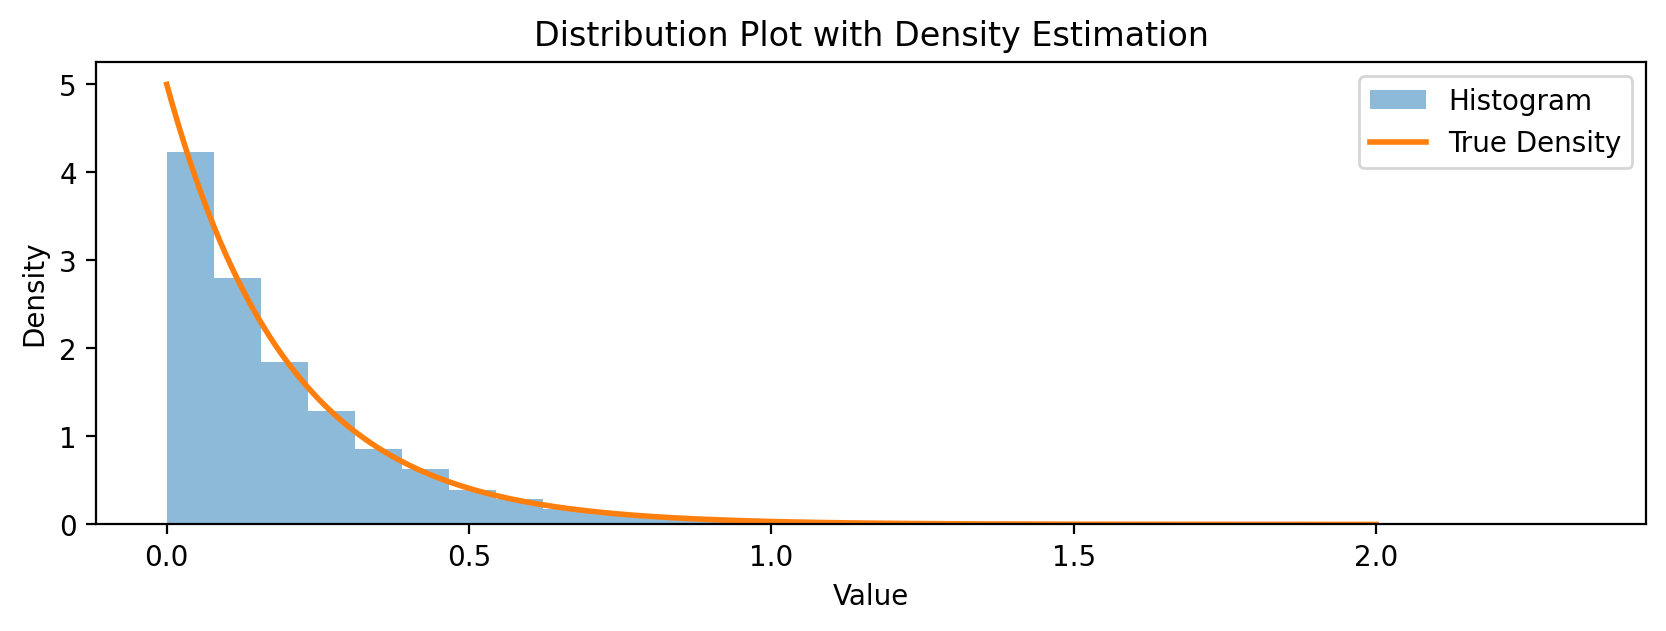

In [222]:
# Plot the histogram of the data (sampled value through inverse cdf)
plt.hist(x, bins=30, density=True, alpha=0.5, label='Histogram')
# Plot the true density function
plt.plot(support, density_values, label='True Density', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Plot with Density Estimation')
plt.legend()

### Example 2: - Truncated Gaussian distribution

We say that $X$ follows a truncated normal distribution with parameters $\mu, \sigma^2, a, b$ if its probability density function is

$$
    f_X(x) = \frac{1}{Z(\mu, \sigma^2, a, b)}\exp\left( -\frac{(x - \mu)^2}{2 \sigma^2} \right) \mathbb I[x \in (a, b)] \propto \exp\left( -\frac{(x - \mu)^2}{2 \sigma^2} \right) \mathbb I[x \in (a, b)]
$$  

We can also compute the normalizing constant:

$$
    Z(\mu, \sigma^2, a, b) = P(Y \in [a, b])
$$
where $Y \sim \mathcal{N} (\mu, \sigma^2)$

Hence 
$$
    Z(\mu, \sigma^2, a, b) = \Phi\left( \frac{b - \mu}{\sigma} \right)  - \Phi\left( \frac{a - \mu}{\sigma} \right)
$$
where $\Phi(z)$ is normal distribution function:
$$
\Phi (z)={\frac {1}{\sqrt {2\pi }}}\int _{-\infty }^{z}e^{-t^{2}/2}\,dt
$$

<!---  <center><img src="./images/normal_cdf.png" width="300" height="200"></center> --->

The cumulative distribution function is then

$$
        F_X(x) =  \begin{cases}
        0 & \text{if } x < a \\
        \frac{1}{Z(\mu, \sigma^2, a, b)} \times \left( \Phi\left( \frac{x - \mu}{\sigma} \right)  - \Phi\left( \frac{a - \mu}{\sigma} \right) \right) & \text{if } a \geq x \geq b \\
        1 & \text{if } x > b
        \end{cases}
$$


The quantile function is then

$$
 F_X(x) = u = \frac{1}{Z(\mu, \sigma^2, a, b)} \times \left( \Phi\left( \frac{x - \mu}{\sigma} \right)  - \Phi\left( \frac{a - \mu}{\sigma} \right) \right)
$$

$$
 Z(\mu, \sigma^2, a, b) u + \Phi\left( \frac{a - \mu}{\sigma} \right)  =  \Phi\left( \frac{x - \mu}{\sigma} \right) 
$$

$$
 \Phi^{-1} \left( Z(\mu, \sigma^2, a, b) u + \Phi\left( \frac{a - \mu}{\sigma} \right) \right)   \sigma + \mu  =  x
$$

In [223]:
def inv_normal_cdf(mu, sigma, a, b, N):
    u = tfp.distributions.Uniform(0,1).sample(N)
    z = tfp.distributions.Normal(0,1).cdf((b - mu) / sigma) - tfp.distributions.Normal(0,1).cdf((a - mu) / sigma)
    return tfp.distributions.Normal(0,1).quantile((z * u + tfp.distributions.Normal(0,1).cdf((a - mu) / sigma))) * sigma + mu   

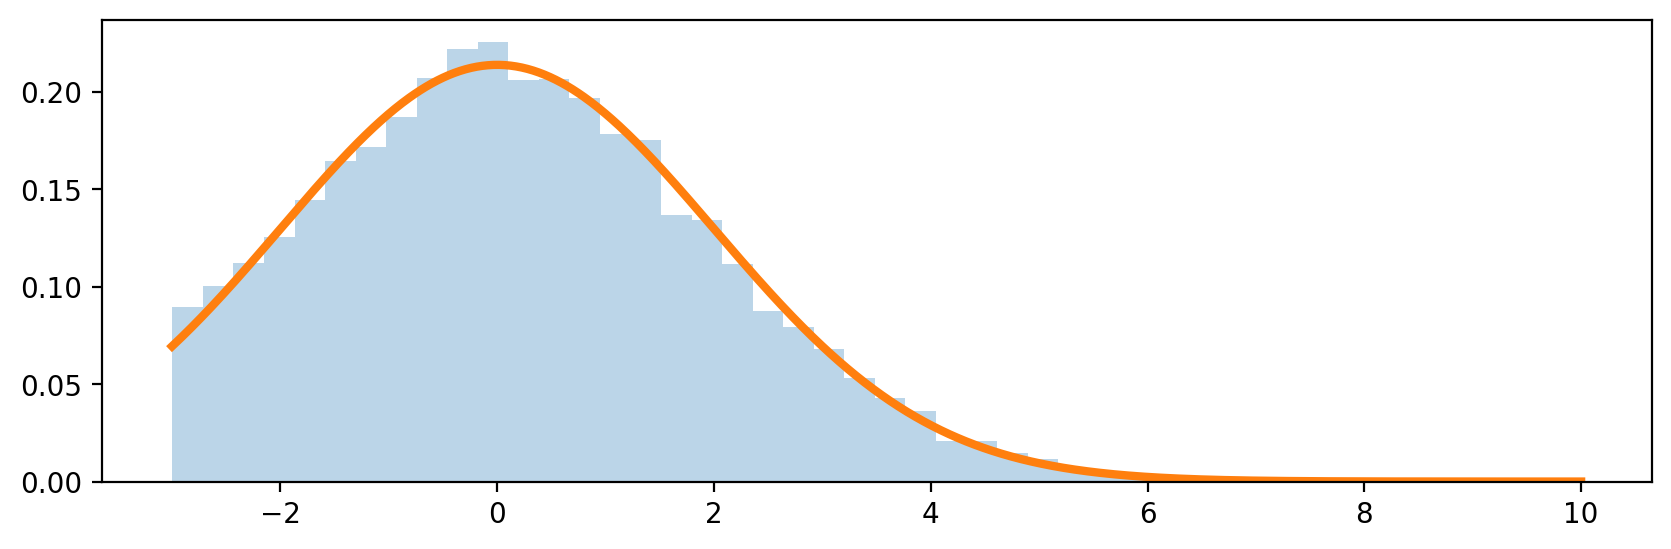

In [224]:
mu = 0
sigma = 2
a = -3
b = 10
N = 10000

# True theoretical pdf
x_values = np.linspace(-3, 10, 1000)
z = tfp.distributions.Normal(0,1).cdf((b - mu) / sigma) - tfp.distributions.Normal(0,1).cdf((a - mu) / sigma)
pdf = tfp.distributions.Normal(0,2).prob(x_values) / z

# Plot true vs sampled
plt.hist(inv_normal_cdf(mu, sigma, a, b, N), density = True, alpha = 0.3, bins="scott")
plt.plot(x_values, pdf, linewidth=3.0)
plt.show()

# Importance Sampling
Importance Sampling is a method for estimate the expectation of a function (**problem 2**).  
Assume we know the true distribution $P(\textbf{x}) = \frac{P(\textbf{x})^*}{Z}$, i.e. we can **evaluate it**, at least up to a moltiplicative costant, but it's **intractable**, i.e. we cannot sample from it becuase it too much complicated.    
Assume we have a simpler density $Q(\textbf{x}) = \frac{Q(\textbf{x})^*}{Z_Q}$, which we are able to sample and evaluate, at least up to a moltiplicative costant (so for which we are able to solve **problem 1**).  
<center><img src="./images/importance_sampling.png" width="300" height="200"></center>  
In importance sampling we generate $R$ samples $\{\textbf{x}_r\}_{r=1}^R$  from $Q(\textbf{x})$.  

If these point were samples from $P(\textbf{x})$ then we could estimate $\Phi$ as $\hat{\Phi} = \frac{1}{R} \sum_r \Phi(\textbf{x}_r)$.  
But when we generate samples from $Q$, value of $x$ for which $Q(\textbf{x})$ is bigger than $P(\textbf{x})$ will be over-represented and value for which $Q(\textbf{x})$ is smaller than $P(\textbf{x})$ will be under-represented. To make into account that we are sampling from wrong distribution, we introduce weights
$$
    w_r = \frac{P(\textbf{x})^*}{Q(\textbf{x})^*}
$$
which we use to adjust the **importance** of each point in our estimator:
$$
    \hat{\Phi} = \frac{\sum_r w_r\phi(\textbf{x}_r)} {\sum_r w_r}
$$
Popular in Reinforcement Learning: e.g. "Importance Sampling Techniques for Policy Optimization" by Metelli et al (2020) Journal of Machine Learning Research.

Can be used also to approximate the intractable distribution $P(\cdot)$

## Example 1 - Importance Sampling with Standard Gaussian distribution

Let 
$$
    p(\theta) = \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-x^2 / 2} \quad\text{and}\quad q(\theta) = \frac{1}{\sqrt{2 \pi} \sigma} \mathrm{e}^{-x^2 / (2 \sigma^2)}
$$
Consider $p(\theta)$ the true intractable distribution.  
Let's compare the performance in estimating $\mathbb E_{\theta \sim p}[\theta]$ using both $p$ and $q$.   
Through $p(\theta)$ and $q(\theta)$ we solve **problem 1** and then we estimate $\Phi = \mathbb E_{\theta \sim p}[\theta]$ with $\hat{\Phi} = \frac{\sum_r w_r\phi(\textbf{x}_r)} {\sum_r w_r}$, that collapse to $\hat{\Phi} = \frac{1}{R} \sum_r \phi(\textbf{x}_r)$ in the case of $p$, i.e. the standard monte carlo estimate.  
$\phi(x) = x$ in this case.

In [225]:
N = 10000
x_values = np.linspace(-5,5,N)

# true distribution
p = tfp.distributions.Normal(0,1)

# sample distributions - case equal to p
q1 = p
x1 = q1.sample(N)
w1 = p.prob(x1)/q1.prob(x1)
phi1 = np.sum(w1 * x1)/np.sum(w1)
phi1_1 = np.sum(x1)/N

# sample distributions - case equal to q, sigma fixed to 2
sigma = 2
mu = 0
q2 = tfp.distributions.Normal(mu, sigma)
x2 = q2.sample(N)
w2 = p.prob(x2)/q2.prob(x2)
phi2 = np.sum(w2 * x2)/np.sum(w2)
phi2_1 = np.sum(x2)/N

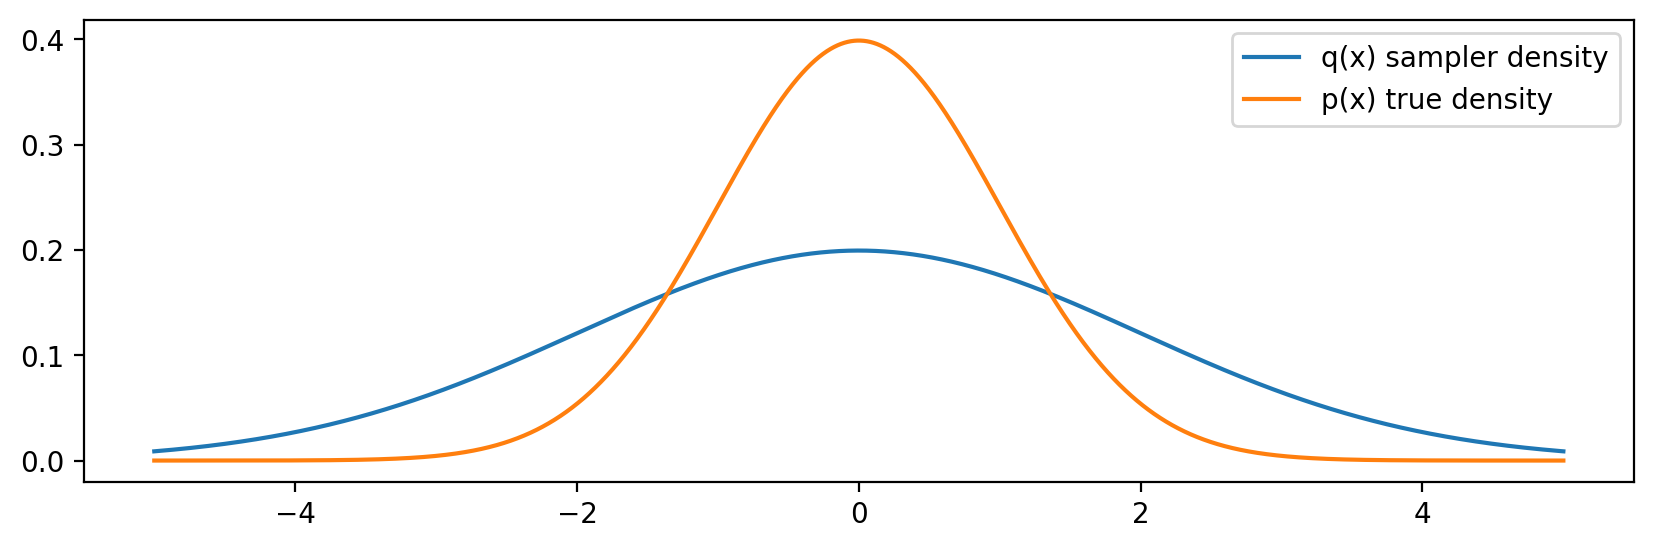

In [226]:
plt.plot(x_values, q2.prob(x_values), label= "q(x) sampler density")
plt.plot(x_values, p.prob(x_values), label="p(x) true density")
plt.legend()

In [227]:
print(np.sum(w1))
print(phi1)
print(phi1_1)

10000.0
-0.017138842
-0.0171388427734375


In [228]:
print(np.sum(w2))
print(phi2)
print(phi2_1)
err2 = (0 - phi2) * (0 - phi2)
err2_1 = (0 - phi2_1) * (0 - phi2_1)
print(err2)
print(err2_1)

9978.542
0.00016908401
0.00045701503753662107
2.858940395519315e-08
2.0886274453459916e-07


Look how $p(x)$ is obviously better at estimating $\Phi$.  
Let's also look how the standard monte varlo estimate perform w.r.t importance sampling in the case of $q(x)$: the performance seems dependnt on the sample.  
Let's now look at the convergence behavior of both:

In [229]:
N = 1000

# true distribution
p = tfp.distributions.Normal(0,1)

# sample distributions - case equal to p
q1 = p
x1 = q1.sample(N)
w1 = p.prob(x1)/q1.prob(x1)
phi1 = np.cumsum(w1 * x1)/np.cumsum(w1)
phi1_1 = np.cumsum(x1)/np.arange(1,N+1)

# sample distributions - case equal to q, sigma fixed to 2
sigma = 2
mu = 0
q2 = tfp.distributions.Normal(mu, sigma)
x2 = q2.sample(N)
w2 = p.prob(x2)/q2.prob(x2)
phi2 = np.cumsum(w2 * x2)/np.cumsum(w2)
phi2_1 = np.cumsum(x2)/np.arange(1,N+1)

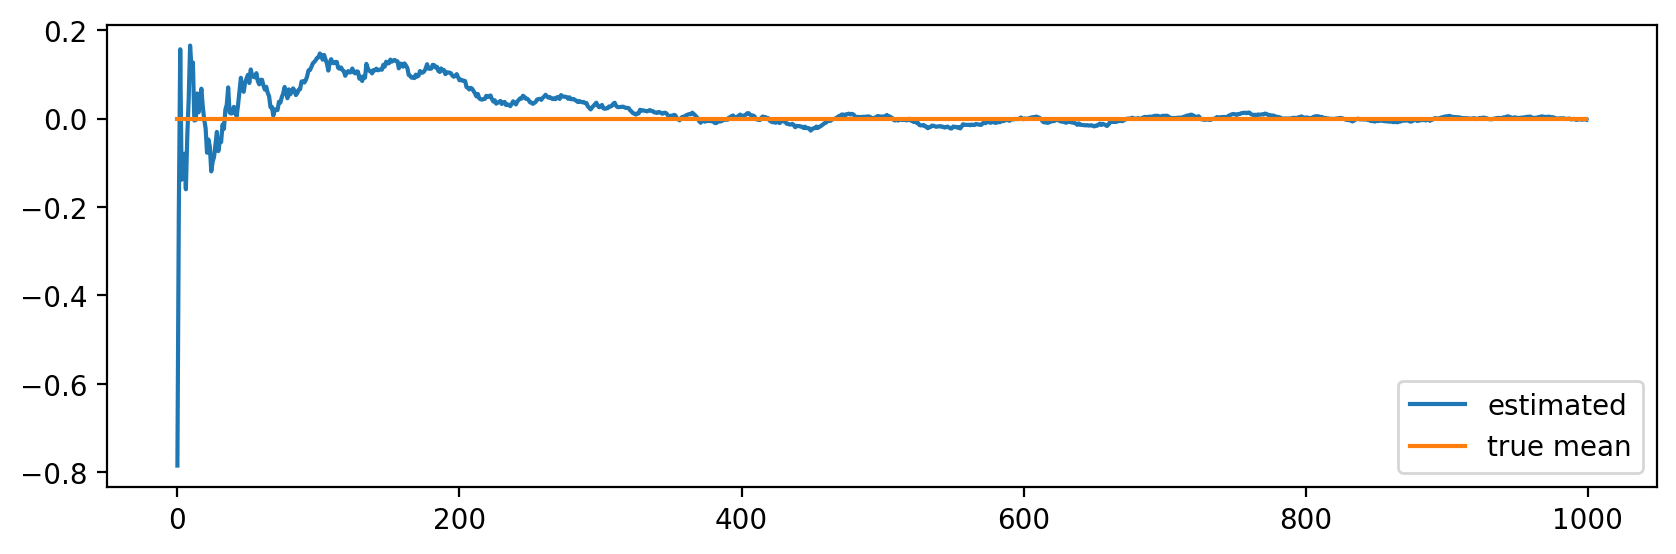

In [230]:
# standard monte carlo estimate with sample from the real distribution
plt.plot(phi1, label="estimated")
plt.plot(np.zeros(N), label="true mean")
plt.legend()

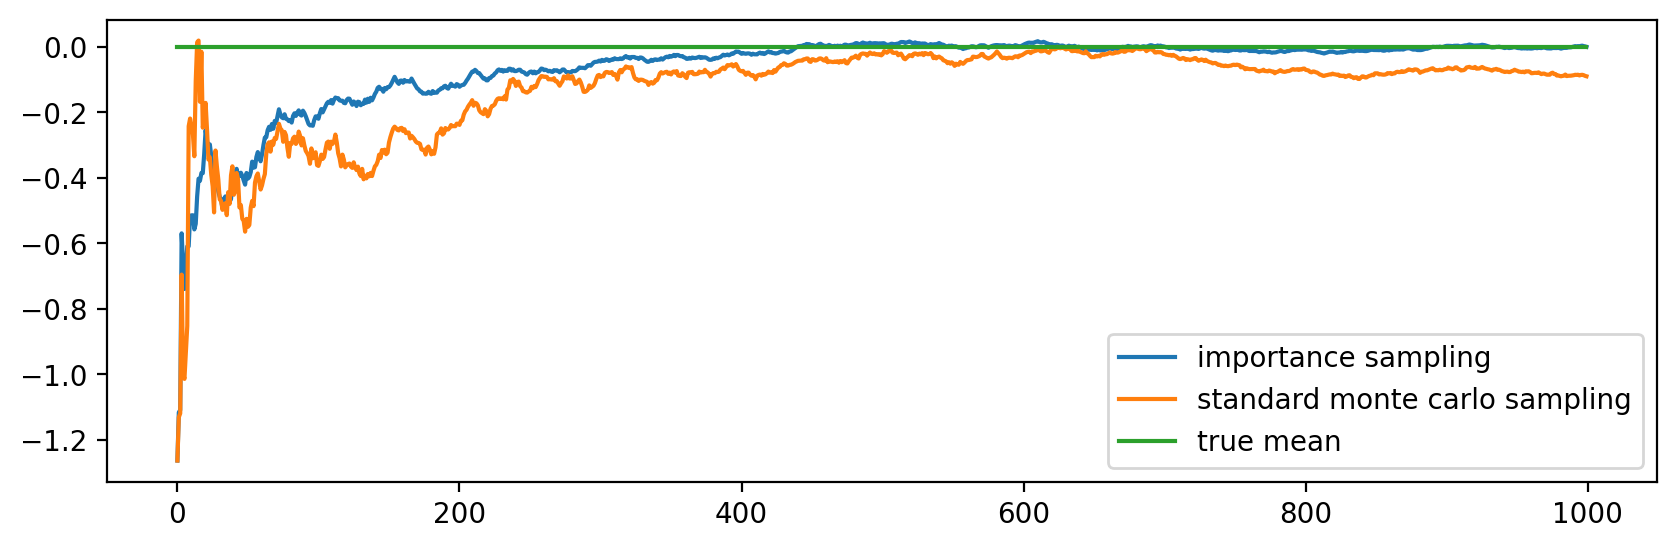

In [231]:
plt.plot(phi2, label="importance sampling")
plt.plot(phi2_1, label="standard monte carlo sampling")
plt.plot(np.zeros(N),label="true mean")
plt.legend()

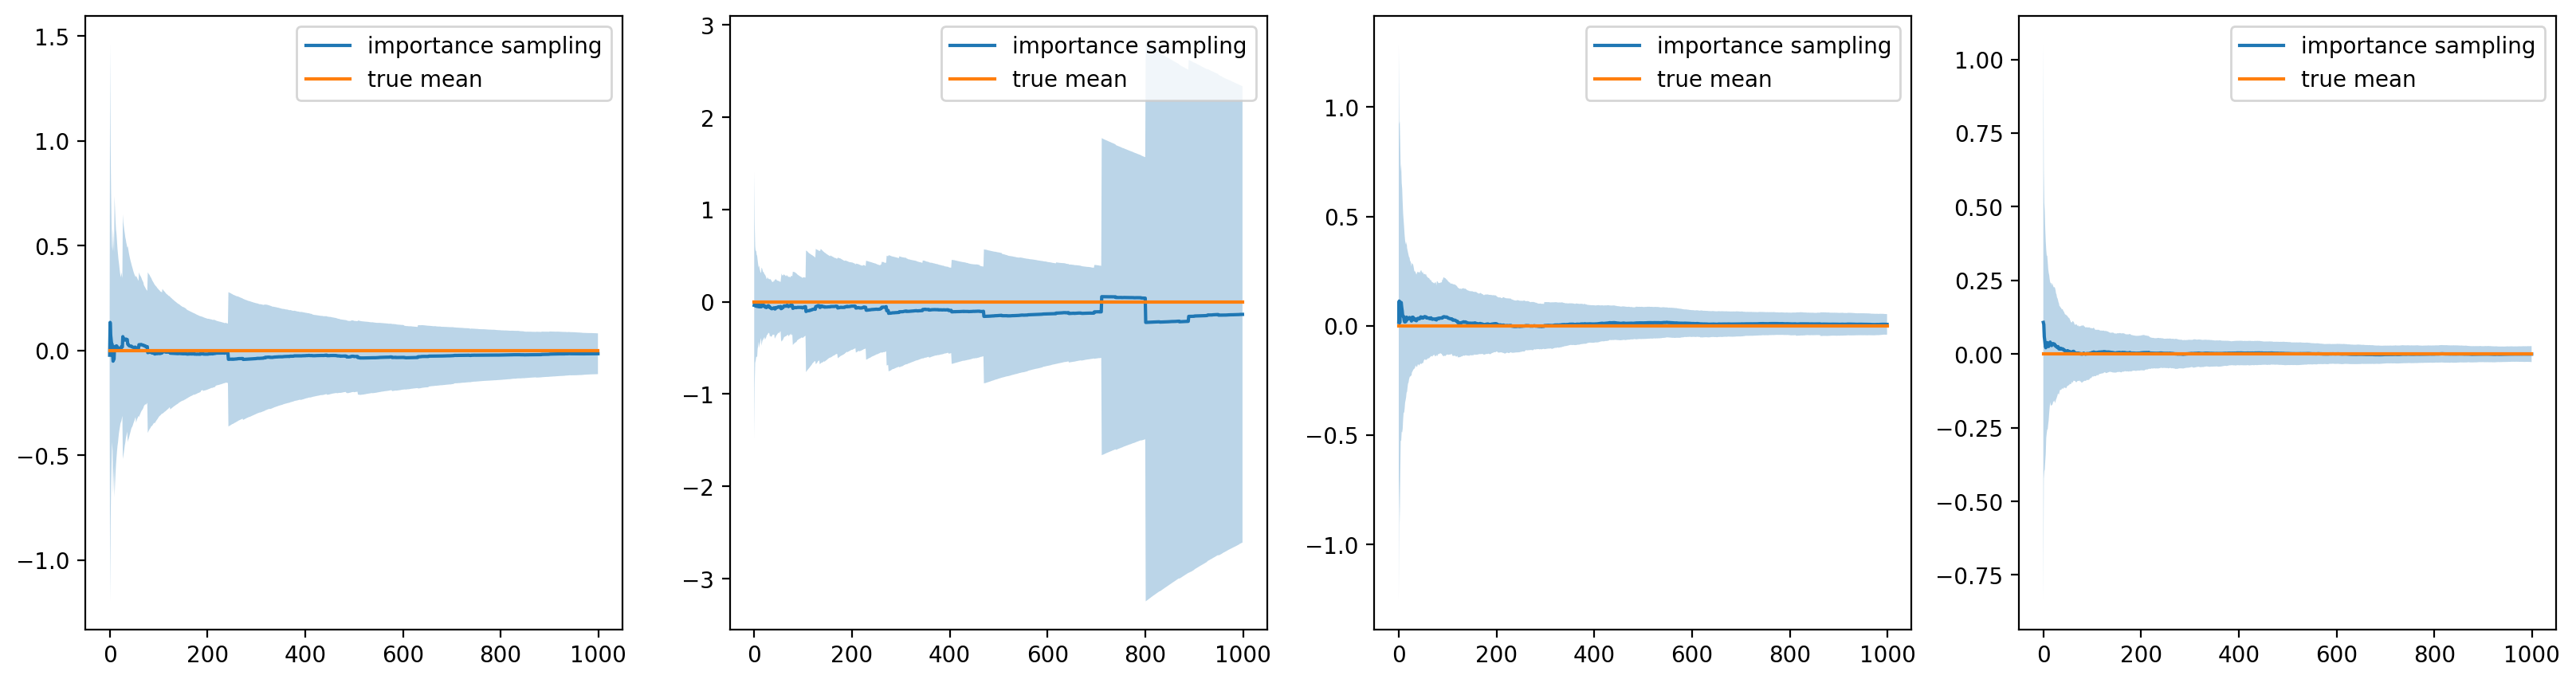

In [232]:
# Importance sampling varying sigma, and averaging over nreps repetition each generating nsamples samples
# Plot the mean phi(avg) over the repetition with the standard deviation in function of the number of samples
sigmas = [0.2, 0.4, 0.8, 1.5]

nreps = 100
nsamples = 1000


fig, axes = plt.subplots(nrows=1, ncols=len(sigmas), figsize=(20, 5))
for i in range(len(sigmas)):
    thetas = tfp.distributions.Normal(0, sigmas[i]).sample((nreps, nsamples))
    weighted_thetas = thetas * tfp.distributions.Normal(0, 1).prob(thetas) / tfp.distributions.Normal(0, sigmas[i]).prob(thetas)
    phi = np.cumsum(weighted_thetas, axis = 1) / np.arange(1, nsamples + 1)
    mean = np.mean(phi, axis = 0)
    sd = np.std(phi, axis = 0)
    axes[i].plot(mean, label="importance sampling")
    axes[i].plot(np.zeros(nsamples), label="true mean")
    axes[i].fill_between(np.arange(nsamples), mean - sd, mean + sd, alpha=0.3)
    axes[i].legend()
plt.show()

## Example 2- Importance Sampling for posterior inference on the `VetBP` dataset
Assume the following data model
\begin{equation*}
\begin{aligned}
    y_1, \ldots, y_n \mid \mu, \sigma & \stackrel{\tiny\mbox{iid}}{\sim} \mathcal{N}(\mu, \sigma^2) \\
    \mu & \sim \mathcal{N}(124, 7.5^2) \\
    \sigma & \sim \text{logN}(\log(13.43), 0.5)
\end{aligned}
\end{equation*}

The objective is to compute the posterior mean 
$$
     \mathbb{E}[\sigma | \textbf{y}]
$$

Consider the following proposal distributions:
$$
    Q(\mu, \sigma) = \mathcal{N}(\mu; 134.5, 10) \times \mathcal{N}(\hat \sigma, 2)
$$
where $\hat \sigma = \frac{1}{n} \sqrt{\sum (y_i - 134.5)^2}$.

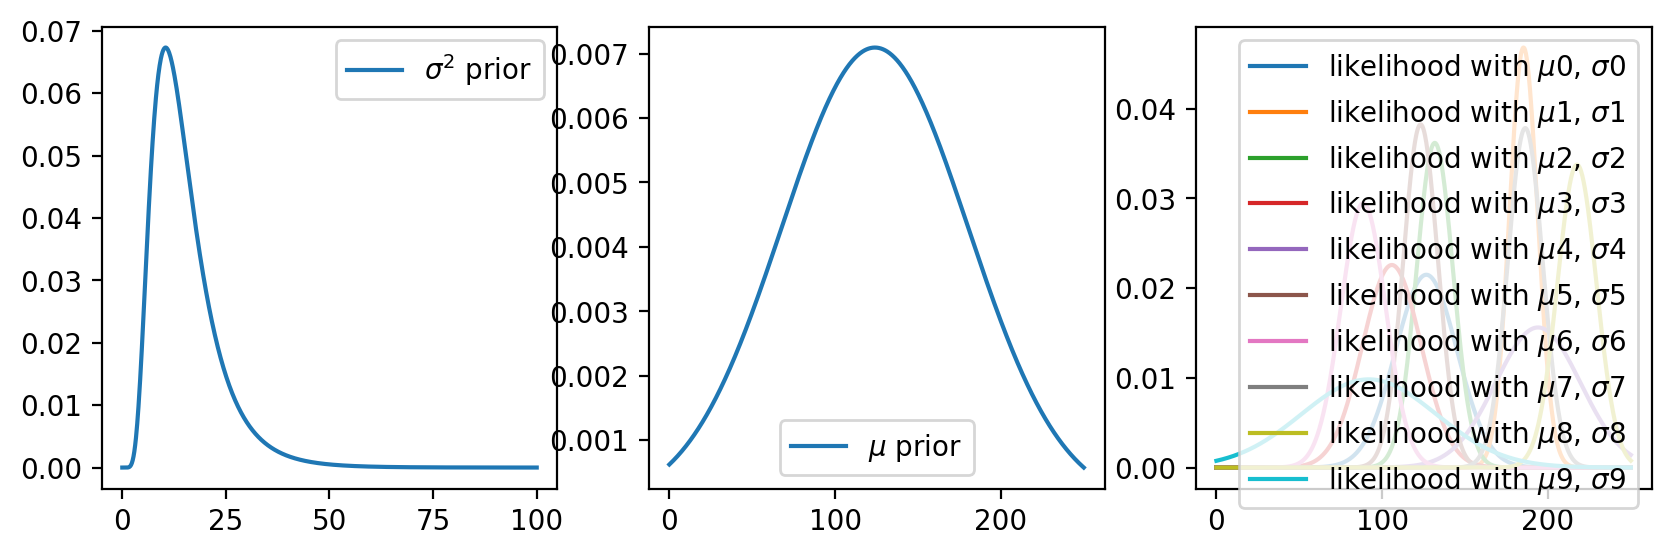

In [233]:
fig, axes = plt.subplots(nrows=1, ncols=3)

sigrange = np.linspace(0.01, 100, 1000)
axes[0].plot(sigrange, tfp.distributions.LogNormal(np.log(13.43), 0.5).prob(sigrange), label = "$\sigma^2$ prior")
axes[0].legend()

murange = np.linspace(0.01, 250, 1000)
axes[1].plot(murange, tfp.distributions.Normal(124, 7.5**2).prob(murange), label = "$\mu$ prior")
axes[1].legend()

nsamples = 10
datarange = np.linspace(0.01, 250, 1000)
mu = tfp.distributions.Normal(124, 7.5**2).sample(nsamples)
sigma = tfp.distributions.LogNormal(np.log(13.43), 0.5).sample(nsamples)
for i in np.arange(nsamples):
    axes[2].plot(datarange, tfp.distributions.Normal(mu[i], sigma[i]).prob(datarange), label = f"likelihood with $\mu{i}$, $\sigma{i}$")
axes[2].legend()

Data $y_i$ is from the <code>vetBP</code> dataset:

(array([  1.,  20.,  47., 108., 117.,  70.,  30.,   8.,   2.,   1.]),
 array([ 86. ,  97.4, 108.8, 120.2, 131.6, 143. , 154.4, 165.8, 177.2,
        188.6, 200. ]),
 <BarContainer object of 10 artists>)

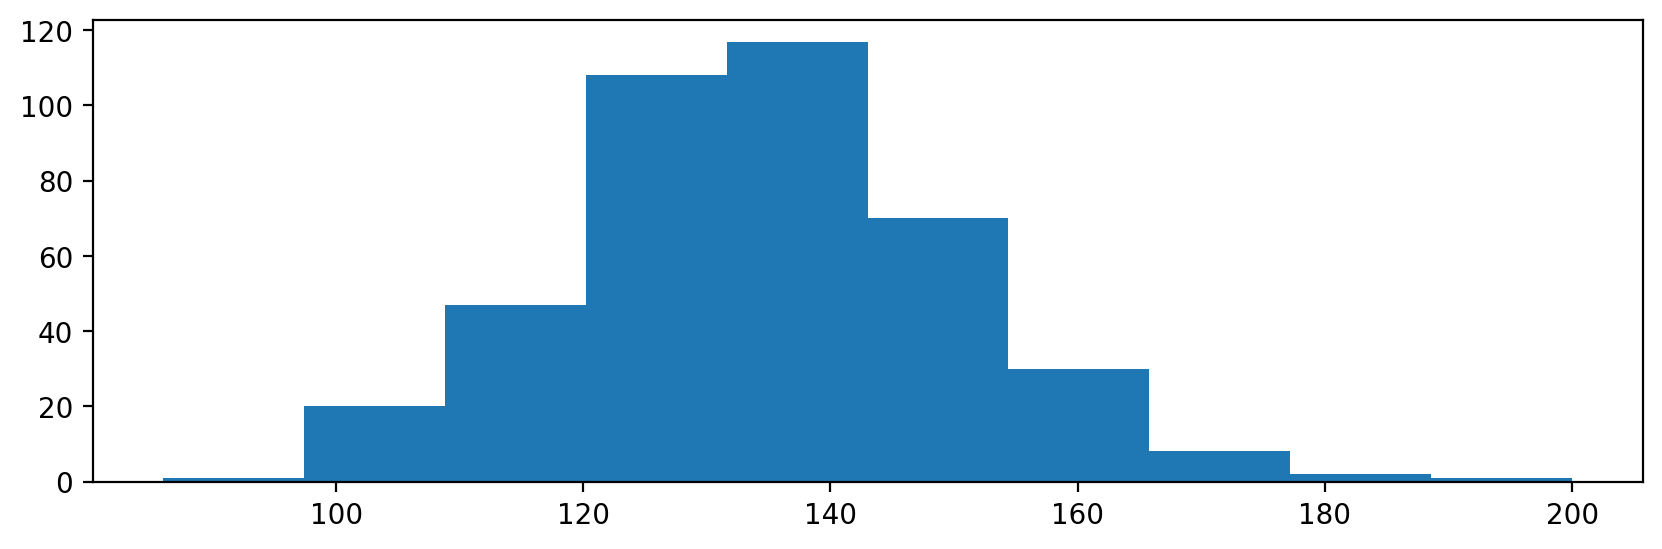

In [234]:
df = pd.read_csv("./data/vetbp.csv")
data = df["SBP_00"].values
plt.hist(data)

In [235]:
np.mean(data)

134.49257425742573

Refer to Ex 5 Notebook in the class notes to the explanation of the below code (TODO: add latex explanations formula)

In [236]:
def sample_q(size, mu_prop_center, mu_prop_dev, sigma_prop_center, sigma_prop_dev):
    return np.dstack((
        tfp.distributions.Normal(mu_prop_center, mu_prop_dev).sample(size),
        tfp.distributions.Normal(sigma_prop_center, sigma_prop_dev).sample(size)
    ))[0, :, :]

In [237]:
def normalized_weights(size, data, prior_samples, 
                       mu_prior_center, mu_prior_sigma, 
                       sigma_prior_center, sigma_prior_dev,
                       mu_prop_center, mu_prop_dev, sigma_prop_center, sigma_prop_dev): 
    # compute: p(mu, sigma | y) = L(y| mu, sigma)*p(mu)*p(sigma) 
    # taking the log the * becomes +

    log_likelihood = np.sum(tfp.distributions.Normal(prior_samples[:, 0], prior_samples[:, 1]).log_prob(data[:, np.newaxis]), axis=0) 
    # log_prob(data[:, np.newaxis]), axis=0): this trick allows passing all the data once and recover the associated probability for all prior samples

    log_priors = tfp.distributions.Normal(mu_prior_center, mu_prior_sigma).log_prob(prior_samples[:, 0]) + \
                    tfp.distributions.LogNormal(sigma_prior_center, sigma_prior_dev).log_prob(prior_samples[:, 1])

    log_prop = tfp.distributions.Normal(mu_prop_center, mu_prop_dev).log_prob(prior_samples[:, 0]) + \
                    tfp.distributions.Normal(sigma_prop_center, sigma_prop_dev).log_prob(prior_samples[:, 1])

    log_posterior = log_likelihood + log_priors

    log_weights = log_posterior - log_prop

    #normalized_weights = np.exp(log_weights) / np.sum(np.exp(log_weights))  # fix variable name
    # We should compute np.exp(weights) / np.sum(np.exp(weights)) --> leads to numerical errors
    # Instead, use the "logsumexp" trick
    # https://en.wikipedia.org/wiki/LogSumExp
    
    log_norm_weights = log_weights - logsumexp(log_weights)

    return np.exp(log_norm_weights)  

In [238]:
size = 1000
mu_prior_center = 124
mu_prior_sigma = 7.5
sigma_prior_center = np.log(13.43)
sigma_prior_dev = 0.5
mu_prop_center = 134.5
mu_prop_dev = np.sqrt(10)
sigma_prop_center = np.std(data)
sigma_prop_dev = np.sqrt(2)

In [239]:
prior_samples = sample_q(size, mu_prop_center, mu_prop_dev, sigma_prop_center, sigma_prop_dev)
prior_samples.shape

(1000, 2)

In [240]:
weights = normalized_weights(size, data, prior_samples, 
                                 mu_prior_center, mu_prior_sigma, 
                                     sigma_prior_center, sigma_prior_dev, 
                                         mu_prop_center, mu_prop_dev, 
                                             sigma_prop_center, sigma_prop_dev)

In [241]:
# Compute the E[sigma | y] 
sigma_posterior_mean = np.sum(weights * prior_samples[:, 1])
sigma_posterior_mean

15.544814767963125

In [242]:
print("Sum of weights: ", np.sum(weights))

Sum of weights:  0.99999999999993


Below some theory taken from the original prof notebook that can be usefeul in the future

## Effective sample size
The effective sample size (ESS) is an estimate of the sample size required to achieve the same level of precision if that sample was a simple random sample. Mathematically, it is defined as n/D, where n is the sample size and D is the design effect. It is used as a way of summarizing the amount of information in data.

In [243]:
ess = 1.0 / np.sum(weights ** 2)
print("ess: ", ess)

ess:  177.630465361533


# Rejection Sampling
Rejection Sampling is a method for sampling from a given distribution (**problem 1**).   
As in importance sampling assume we know the true distribution $P(\textbf{x}) = \frac{P(\textbf{x})^*}{Z}$, i.e. we can **evaluate it**, at least up to a moltiplicative costant, but it's **intractable**, i.e. we cannot sample from it becuase it too much complicated.    
Assume we have a simpler density $Q(\textbf{x}) = \frac{Q(\textbf{x})^*}{Z_Q}$, which we are able to sample and evaluate, at least up to a moltiplicative costant (so for which we are able to solve **problem 1**). 
In addition now, we assume also that we know the value of a costant $c$ such that
$$
    cQ(\textbf{x})^* > P(\textbf{x})^*  \text{for all x}
$$
We generate two random number. The first, $x$ is generated from the proposal density $Q(\textbf{x})^*$. We then evaluate $cQ(\textbf{x})^*$ and generateba uniformly distribuited random variable $u$ from the interval $[0, cQ(\textbf{x})^*]$. These two random number can be viewed as as selecting a point in the two-dimensional plane as showed in the figure.

<center><img src="./images/rejection_sampling.png" width="500" height="400"></center> 

We now evaluate $P(\textbf{x})^*$ and accept or reject the sample $x$ by comparing the value of $u$ with the value of $P(\textbf{x})^*$:
- if $u \leq P(\textbf{x})^*$ then $x$ is **accepted**
- if $u > P(\textbf{x})^*$ then $x$ is **rejectd**

The proposed point $(x, u)$ comes with uniform probability from the lightly shaded area underneath the curve $cQ(\textbf{x})^*$. The rejection rule reject all the points that lie above the curve $cP(\textbf{x})^*$. So the points $(x,u)$ that are accepted are uniformly didstribuited in the heavily shaded area under $P(\textbf{x})^*$. This implies that the probability density of the $x$-coordinates of the accepted points must be proportional to $P(\textbf{x})^*$, so the samples must be independent samples from $P(\textbf{x})$.
If $Q$ is too much different from $P$ then $c$ will be necessarily be large and the frequency of the rejecton will be large.  
The acceptance probability is $P(\textbf{x})^* / cQ(\textbf{x})^*$.

## Example 3: rejection sampling with exercise 2 of 9 June 2022
Consider
$$
    P(z) = \frac{2}{\sqrt{2 \pi}} e^{z^2 / 2} \mathbb{1}_{(0, +\inf)} (z)
$$

and 

$$
    Q(z) = \lambda e^{- \lambda z} \mathbb{1}_{(0, +\inf)} (z), \lambda>0
$$

Note how $P(z)$ does not exist in tensorflow probability and how instead $Q(z)$ is simply an exponential distribution.

In [244]:
def P(x):
    return np.where(x > 0, 2 / np.sqrt(2*np.pi) * np.exp(-x**2 / 2), 0) #where allow for vectorized operation of if/else on an numpy array
    

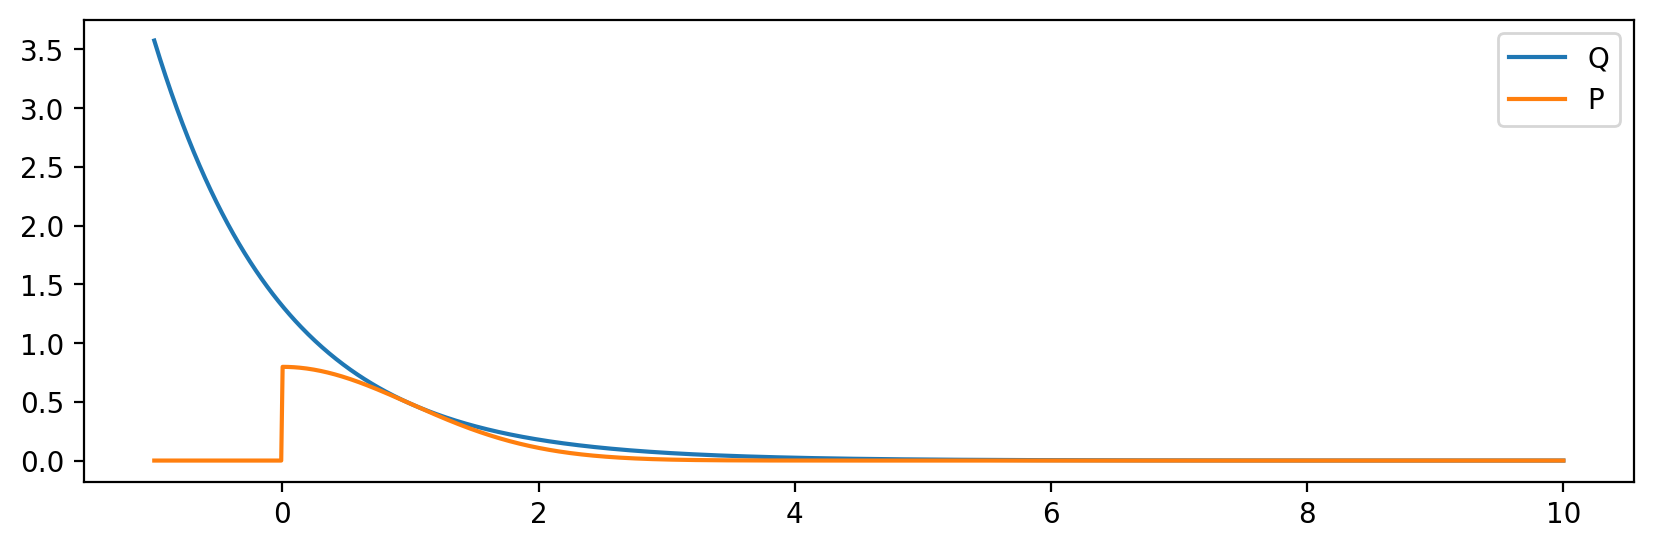

In [245]:
rate = 1
M = 2 / (rate * np.sqrt(2*np.pi)) * np.exp(rate**2 / 2)
x = np.linspace(-1, 10, 1000)
plt.plot(x,M * tfp.distributions.Exponential(1).prob(x), label = "Q")
plt.plot(x, P(x), label = "P")
plt.legend()

In [246]:
def rejection_sampling(rate = 1):

    while True:
        # Defining M (see exrcises notes)
        M = 2 / (rate * np.sqrt(2*np.pi)) * np.exp(rate**2 / 2)
             
        # sample from Q
        x = tfp.distributions.Exponential(rate).sample()

        # sample from U[0, M*Q(x)], evaluating Q at x
        u = tfp.distributions.Uniform(0, M*tfp.distributions.Exponential(rate).prob(x)).sample()

        if u < P(x):
            return x

We can also use the folowing version

In [247]:
def rejection_sampling(rate = 1):

    while True:
        # Defining M (see exrcises notes)
        M = 2 / (rate * np.sqrt(2*np.pi)) * np.exp(rate**2 / 2)
             
        # sample from Q
        x = tfp.distributions.Exponential(rate).sample()

        # sample from U[0, 1]
        u = tfp.distributions.Uniform().sample()

        if u < P(x) / (M*tfp.distributions.Exponential(rate).prob(x)):
            return x

Or the following vectorized version (thanks to https://jaketae.github.io/study/rejection-sampling/)

In [248]:
def rejection_sampling_vectorized(nsamples, rate = 1):
    # Defining M (see exrcises notes)
    M = 2 / (rate * np.sqrt(2*np.pi)) * np.exp(rate**2 / 2)
    
    # sample from Q
    xs = tfp.distributions.Exponential(rate).sample(nsamples)

    # sample from U[0, 1]
    u = np.random.uniform(0, 1, size=nsamples)
    mask = P(xs) / (M * tfp.distributions.Exponential(rate).prob(xs)) > u
    return xs[mask] 

In [249]:
samples = np.array([rejection_sampling(1) for _ in np.arange(1000)])

In [250]:
samples = rejection_sampling_vectorized(10000000) # molto più veloce

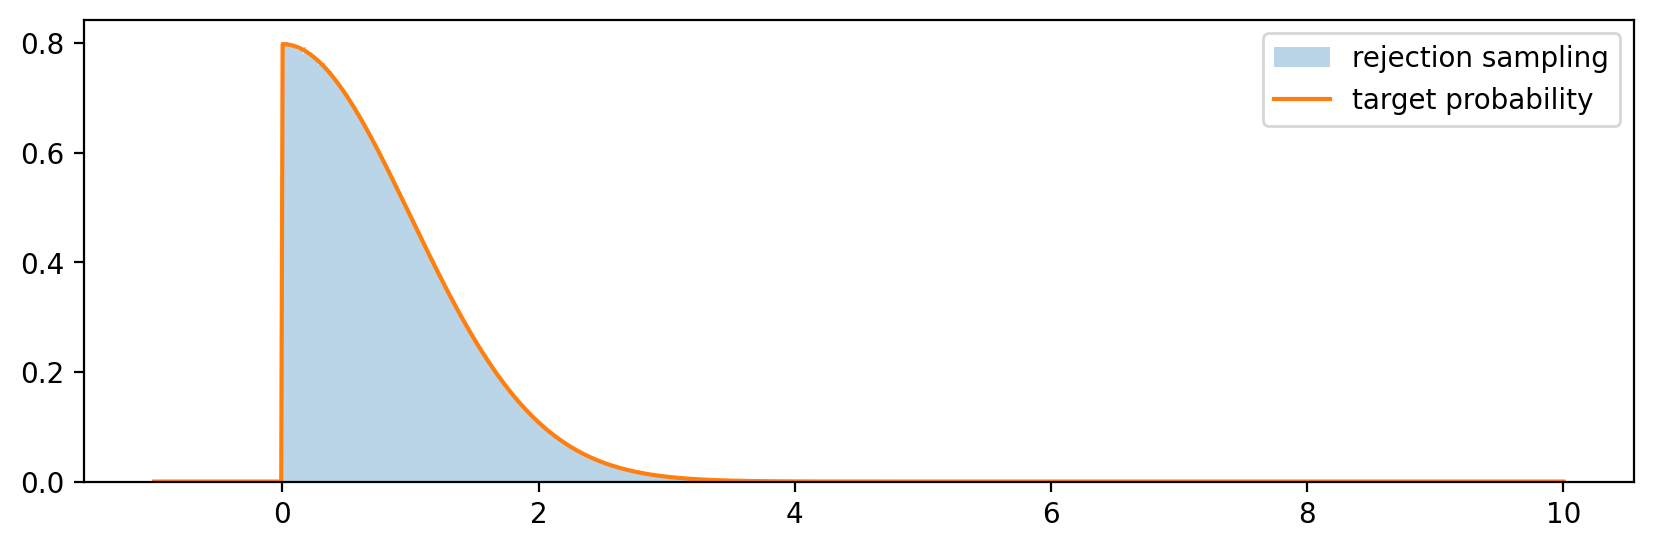

In [251]:
x = np.linspace(-1, 10, 1000)
plt.hist(samples, label = "rejection sampling", density = True, alpha = 0.3, bins="scott")
plt.plot(x, P(x), label = "target probability")
plt.legend()

In [252]:
# Note: if you don't know how to derive analitically the optmal M you can set it as
# M = max(P(x) / Q(x))

# Markov Chain Monte-Carlo sampling: Metropolis-Hasting algorithm
Metropolis-Hasting and more in general MCMC algorihtm solves **problem 1**.  
Assume we know the true distribution $P(\textbf{x}) = \frac{P(\textbf{x})^*}{Z}$, i.e. we can **evaluate it**, at least up to a moltiplicative costant, but it's **intractable**, i.e. we cannot sample from it becuase it too much complicated.    
Assume we have a simpler density $Q(\textbf{x}) = \frac{Q(\textbf{x})^*}{Z_Q}$, which we are able to sample and evaluate, at least up to a moltiplicative costant (so for which we are able to solve **problem 1**).  
Importance and Rejection sampling only works well if the proposal density $Q(x)$  is similar to $P(x)$. In large and complex problem is difficult to create a single density $Q(x)$ that has this property.  
The Metropolis-Hastings algorithm instead makes use of a proposal density  $Q$ which **depends on current state $x^{(t)}$**.  
The density $Q(x^{'}| x^{(t)})$ might in the simplest cases be a simpled distribution such as gaussian centered on the current state $x^{(t)}$.   
It's not necessary for $Q(x^{'}| x^{(t)})$ to look similar to $P(x)$. See the image below:

<center><img src="./images/metropolis.png" width="600" height="400"></center> 

As before: assume we can evaluate $P(x)$ for any $x$.  
A tentative new state $x^{'}$ is generated from the proposal density $Q(x^{'}| x^{(t)})$.  
To decide whetever to accept the new state, compute the quantity 
$$
   a = \frac{P^*(x^{'})}{P^*(x^{(t)})} \frac{Q(x^{(t)}| x^{'})}{Q(x^{'}| x^{(t)})}
$$
- **If** $a \geq 1$ then the new state in **accepted**.
- **If** $a < 1$, the new state is **accepted with probability** $a$.
- **If** the step is **accepted**  $\Rightarrow$   set $x^{(t+1)} = x^{'}$
- **If** the step is **rejected**  $\Rightarrow $ set $x^{(t+1)} = x^{(t)}$

Note that using $Q$ symmetric, the term $\frac{Q(x^{(t)}| x^{'})}{Q(x^{'}| x^{(t)})}$ becomes $1$ and thus is negligible.  
Note the difference from Rejection sampling: in rejection sampling, rejected point are discarded and have no influence on the list of samples ${x^{(r)}}$ that we collect.  
Here a rejection causes the current state $x^{(t)}$ to be written onto the list of points another time.  
It can be shown that for any positive $Q$, as $t \rightarrow  \infty$, the probability distribution of $x^{(t)}$ tends to  $P(\textbf{x}) = \frac{P(\textbf{x})^*}{Z}$.  

The Metropolis method is an example of **Markov chain Monte Carlo method (MCMC)**. In contrast to rejection sampling where the accepted points ${x^{(r)}}$ are independent samples from the desired distribution, MCMC methods involves a Markov Process in which the sequences of states ${x^{(t)}}$ is generated, each sample $x^{(t)}$ having a probability distribution that depend on previous value $x^{(t-1)}$.  
Since succesive samples are correlated with each other, the Markov Chain may have to run for a considerable time in order to generate samples that are effectively independet samples from $P$.  
Many implementations of the Metropolis method employ a proposal distribution with a lenght scale $\epsilon$ that is short relative to the lenght scale $L$ of the probable region. See figure below:

<center><img src="./images/metropolis2.png" width="600" height="400"></center> 

For most high-dimensional problems, a large random step from a typical point (that is, a sample from $P(X)$) is very likely to end in a state which has very low probability: such steps are unlikely to be accepted $a$ will be small. If $\epsilon$ is large, movement around the state space will only occur when a transition to a state which has very low probability is actually accepted, or when a large random ste chances to land in another probable state. So the rate of progress will be slow, unless small steps are used.  
Note how $Q$ does not need to be similar to $P$ in MCMC!.

## Example 4: sampling from a multivariate normal distribution with MCMC

In [253]:
def metropolis_hasting(target_distribution, proposal_distribution, initial_point = np.array([0, 0]), iterations = 100):
    samples = np.zeros((iterations+1, initial_point.shape[0]))
    samples[0, :] = initial_point
    
    for i in np.arange(iterations):
        current = samples[i, :];
        proposed = proposal_distribution.sample(current)
        a = target_distribution.eval(proposed)/target_distribution.eval(current) # using symmetric propsal
        if(a >= 1): 
            samples[i+1, :] = proposed
        else: 
            u = np.random.uniform()
            if(u < a):
                samples[i+1, :] = proposed
            else:
                samples[i+1, :] = current
    
    return samples

In [254]:
class NormalProposal:
    def __init__(self, loc = np.array([0, 0]), scale_diag=np.array([1., 1.])):
        self.Normal = tfp.distributions.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
    def eval(self, point):
        return self.Normal.prob(point)
    def sample(self, current):
        jump = self.Normal.sample()
        return current + jump

In [255]:
class MultivariateNormalTarget:
    def __init__(self, loc = np.array([4, 4]), scale_diag=np.array([3., 3.])):
        self.Normal = tfp.distributions.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
    def eval(self, point):
        return self.Normal.prob(point)

In [256]:
samples1 = metropolis_hasting(MultivariateNormalTarget(), NormalProposal())
samples2 = metropolis_hasting(MultivariateNormalTarget(), NormalProposal(), initial_point=np.array([10, 10]))
samples3 = metropolis_hasting(MultivariateNormalTarget(), NormalProposal(), initial_point=np.array([0, 10]))

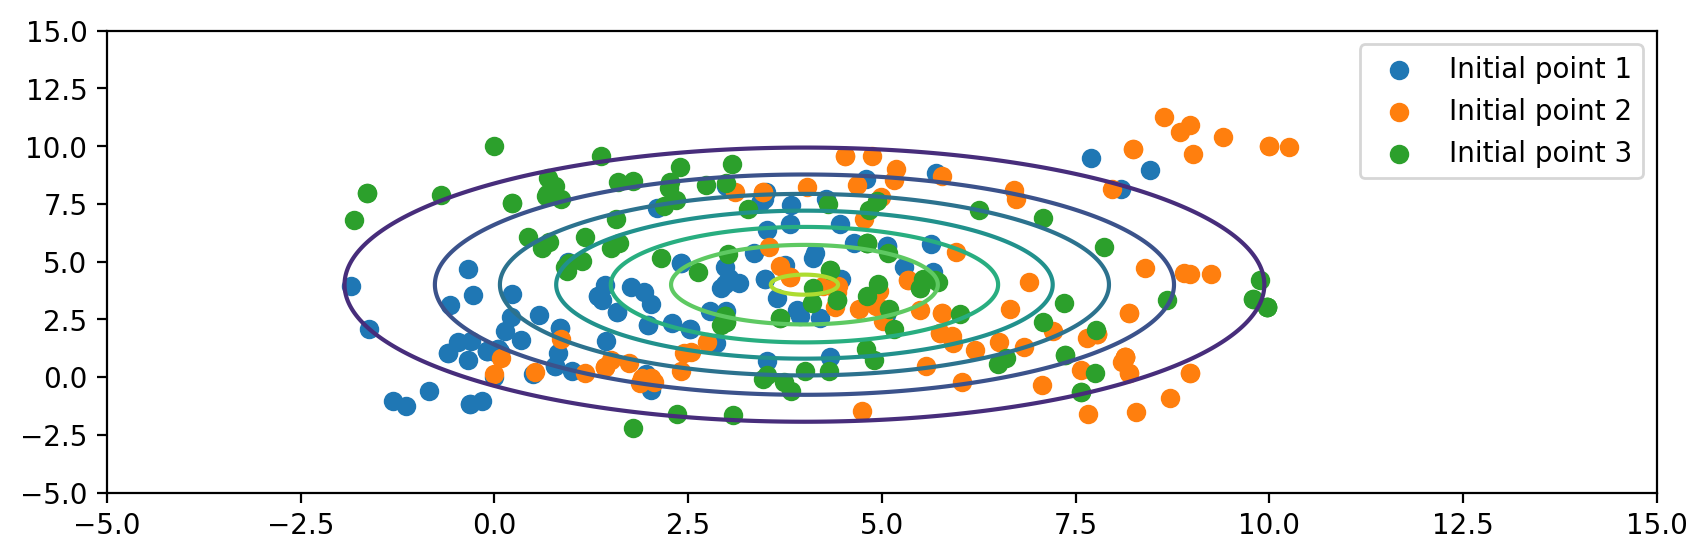

In [257]:
X    = np.linspace(-5, 15, 1000)
Y    = np.linspace(-5, 15, 1000)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))
Z    = tfp.distributions.MultivariateNormalDiag(loc = np.array([4, 4]), scale_diag=np.array([3., 3.])).prob(pos)

plt.contour(X, Y, Z)
plt.scatter(samples1[: ,0], samples1[: ,1], label = "Initial point 1")
plt.scatter(samples2[: ,0], samples2[: ,1], label = "Initial point 2")
plt.scatter(samples3[: ,0], samples3[: ,1], label = "Initial point 3")
plt.legend()
plt.show()

In [258]:
samples1 = metropolis_hasting(MultivariateNormalTarget(), NormalProposal(), initial_point=np.array([-10, 10]),  iterations=1000)

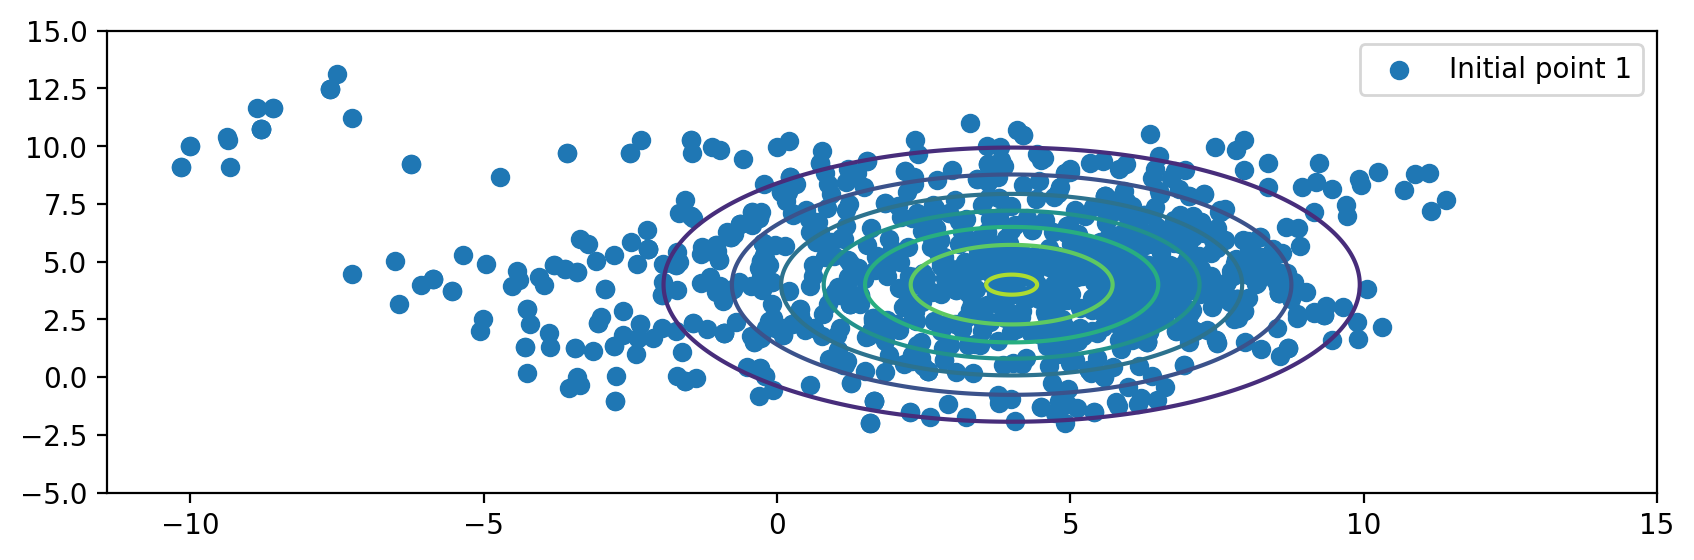

In [259]:
X    = np.linspace(-5, 15, 1000)
Y    = np.linspace(-5, 15, 1000)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))
Z    = tfp.distributions.MultivariateNormalDiag(loc = np.array([4, 4]), scale_diag=np.array([3., 3.])).prob(pos)

plt.contour(X, Y, Z)
plt.scatter(samples1[: ,0], samples1[: ,1], label = "Initial point 1")
plt.legend()
plt.show()

# Gibbs Sampling
Gibbs Sampling is a method for sampling from a distribution of at least two dimensione (__problem 1__).  
It can be viewed as a Metropolis method in which the proposal distribution $Q$ is defined in terms of the conditional distributions of the joint distribution $P(\textbf{x})$. It is assumed that whilst $P(\textbf{x})$ is too complex to draw samples from directly, its conditional distributions $P(x_i | \textbf{x}_{-i})$ are tractable to work with.  
In two dimension, define $\textbf{x}=(x_1; x_2)$.  
On each iteration, we start from the current state $\textbf{x}^{(t)}$, and $x_1$ is sampled from the conditional density $P(x_1 | x_2)$, with $x_2$ fixed to $x_2^{(t)}$. A sample $x_2$ is then made from the conditional density $P(x_2 | x_1)$, using the
new value of $x_1$. This brings us to the new state $\textbf{x}(t+1)$, and completes the iteration.  
In the general case of a system with $K$ variables, a single iteration involves sampling one parameter at a time:  
\begin{align*}
x_{1}^{(t+1)} &\sim P(x_{1} | x_{2}^{(t)}, x_{3}^{(t)}, \dots, x_{K}^{(t)}) \\
x_{2}^{(t+1)} &\sim P(x_{2} | x_{1}^{(t+1)}, x_{3}^{(t)}, \dots, x_{K}^{(t)}) \\
x_{3}^{(t+1)} &\sim P(x_{3} | x_{1}^{(t+1)}, x_{2}^{(t+1)}, \dots, x_{K}^{(t)}), \dots
\end{align*}
Gibbs sampling can be viewed as a Metropolis method which has the property that every proposal is always accepted. Because Gibbs sampling is a Metropolis method, the probability distribution of $\textbf{x}^{(t)}$ tends to $P(\textbf{x})$ as
$t  \xrightarrow[]{} \infty $.

<center><img src="./images/gibbs.png" width="600" height="400"></center> 

## Example: Linear Regression with Gaussian Noise

Gibbs sampling is possible for a simple linear regression model with Gaussian
noise, if the regression coefficients have a Gaussian prior distribution and the
noise precision (reciprocal of variance) has a Gamma prior.

Given n independent observations, $(x_i, y_i)$, consider the model:

\begin{align*}
y_i | x_i, \beta_0, \beta_1, \tau &\sim N(\beta_0 + \beta_1 x_i, 1/\tau) \\
\beta_0 &\sim N(\mu_0, 1/\tau_0) \\
\beta_1 &\sim N(\mu_1, 1/\tau_1) \\
\tau &\sim Gamma(a, b) \\
\end{align*}

with $\mu_0$, $\mu_1$, $\tau_0$, $\tau_1$, $a$, and $b$ are known constants.

We want to sample from the posterior $\pi(\beta_0, \beta_1, \tau | (\textbf{y}, \textbf{x}))$.

The full conditionals are given by:
$$
    \beta_0 | x, y, \beta_1, \tau \sim N\left(\frac{\tau_0 \mu_0 + \tau \sum_i (y_i - \beta_1 x_i)}{\tau_0 + n \tau}, \frac{1}{\tau_0 + n \tau}\right)
$$

$$
    \beta_1 | x, y, \beta_0, \tau \sim N\left(\frac{\tau_1 \mu_1 + \tau \sum_i x_i(y_i - \beta_0)}{\tau_1 + \tau \sum_i x_i^2}, \frac{1}{\tau_1 +  \tau \sum_i x_i^2 }\right)
$$
$$
    \tau | x, y, \beta_0, \beta_1 \sim Gamma \left(a + n/2, b + \sum_i (y_i - \beta_0 - \beta_1 x_i)^2 / 2 \right)
$$

(based on https://kieranrcampbell.github.io/posts/bayesian-linear-regression/)

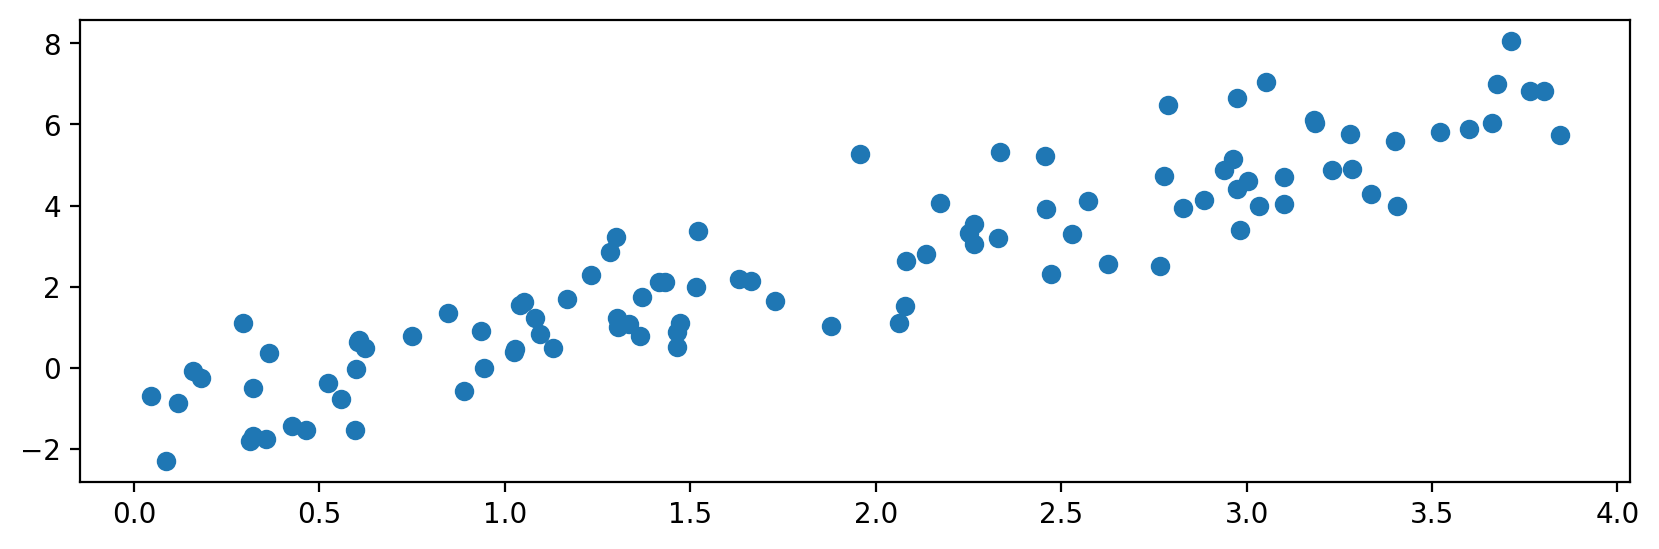

In [260]:
# generate synthetic data
beta_0_true = -1
beta_1_true = 2
tau_true = 1

N = 100
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

plt.plot(x,y, "o")

In [271]:
# set hyperparameters
hyper = {
    "mu_0" : 0,
    "mu_1" : 0,
    "tau_0" : 1,
    "tau_1" : 1,
    "a" : 2,
    "b" : 1
}

# set initial value
init = {
    "beta_0" : 0,
    "beta_1" : 0,
    "tau" : 2
}

In [262]:
def sample_beta_0(x,y, beta_1, tau, tau_0, mu_0):
    n = len(y) 
    precision = tau_0 + n * tau
    mean = (tau_0 * mu_0 + tau * np.sum(y - beta_1*x)) / precision

    return np.random.normal(mean, 1 / np.sqrt(precision))

def sample_beta_1(x,y, beta_0, tau, tau_1, mu_1):
    n = len(y)
    precision = tau_1 + tau * np.sum(x**2)
    mean = (tau_1 * mu_1 + tau * np.sum((y - beta_0) * x)) / precision

    return np.random.normal(mean, 1 / np.sqrt(precision))

def sample_tau(x,y, beta_0, beta_1, a, b):
    n = len(y)
    a_n = a + n/2
    b_n = b + np.sum((y - beta_0 - beta_1 * x)**2) / 2

    return np.random.gamma(a_n, 1 / b_n)

In [263]:
def gibbs_sampler(hyperparameter, initial_value, x, y, n_iter):
    
    beta_0 = initial_value["beta_0"]
    beta_1 = initial_value["beta_1"]
    tau = initial_value["tau"]

    beta_0_chain = np.zeros(n_iter+1)
    beta_0_chain[0] = beta_0
    
    beta_1_chain = np.zeros(n_iter+1)
    beta_1_chain[0] = beta_1
    
    tau_chain = np.zeros(n_iter+1)
    tau_chain[0] = tau

    for t in np.arange(n_iter):

        beta_0_chain[t+1] = sample_beta_0(x,y, beta_1_chain[t], tau, hyperparameter["tau_0"], hyperparameter["mu_0"])
        beta_1_chain[t+1] = sample_beta_1(x,y, beta_0_chain[t], tau, hyperparameter["tau_1"], hyperparameter["mu_1"])
        tau_chain[t+1] = sample_tau(x,y, beta_0_chain[t+1], beta_1_chain[t+1], hyperparameter["a"], hyperparameter["b"])

    return beta_0_chain, beta_1_chain, tau_chain

In [264]:
beta_0_chain, beta_1_chain, tau_chain = gibbs_sampler(hyper, init, x, y, 1000)

beta_0_fit = beta_0_chain[-1] #select last beta_0
beta_1_fit = beta_1_chain[-1]
tau_fit = tau_chain[-1]

In [265]:
trace = np.stack((beta_0_chain, beta_1_chain, tau_chain),axis=1)
trace = pd.DataFrame(trace)
trace.columns = ["beta_0", "beta_1", "tau"]

<Axes: >

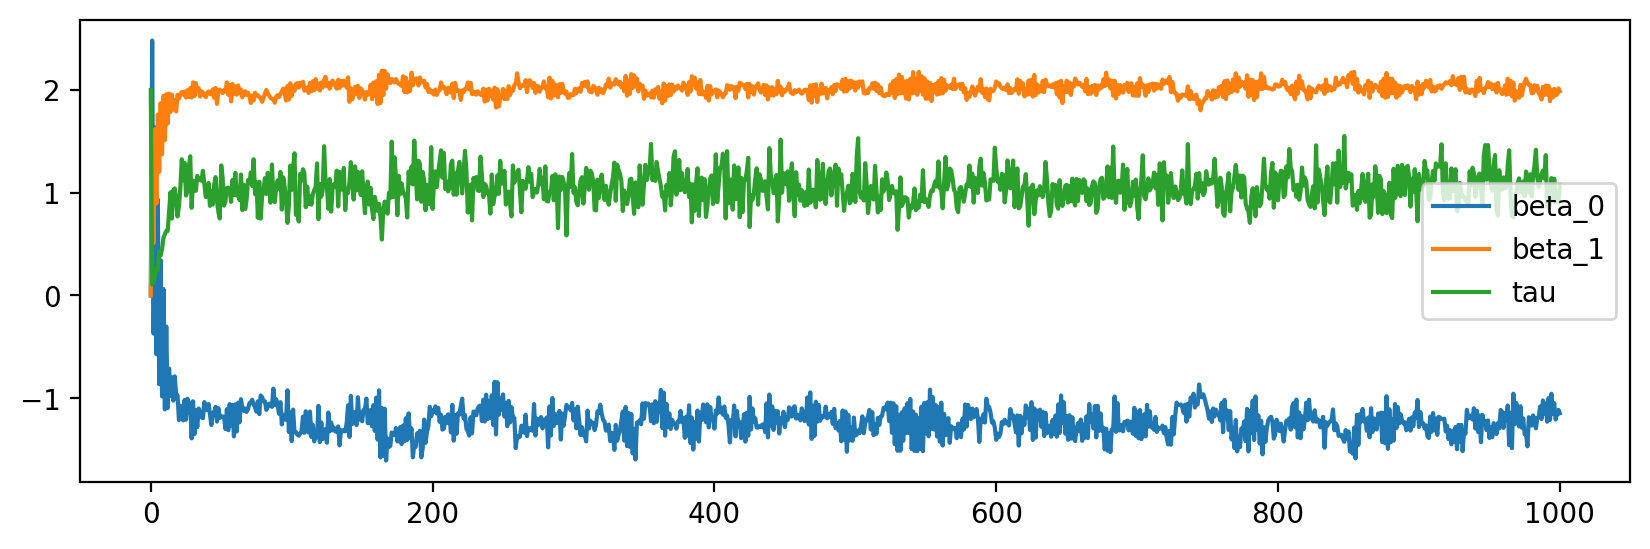

In [266]:
trace.plot()

In [267]:
print("true beta_0:", beta_0_true, "fitted beta_0:", beta_0_fit)
print("true beta_1:", beta_1_true, "fitted beta_0:", beta_1_fit)
print("true tau:", tau_true, "fitted tau:", tau_fit)

true beta_0: -1 fitted beta_0: -1.1462095408264275
true beta_1: 2 fitted beta_0: 1.986683895118421
true tau: 1 fitted tau: 1.0776514624285831


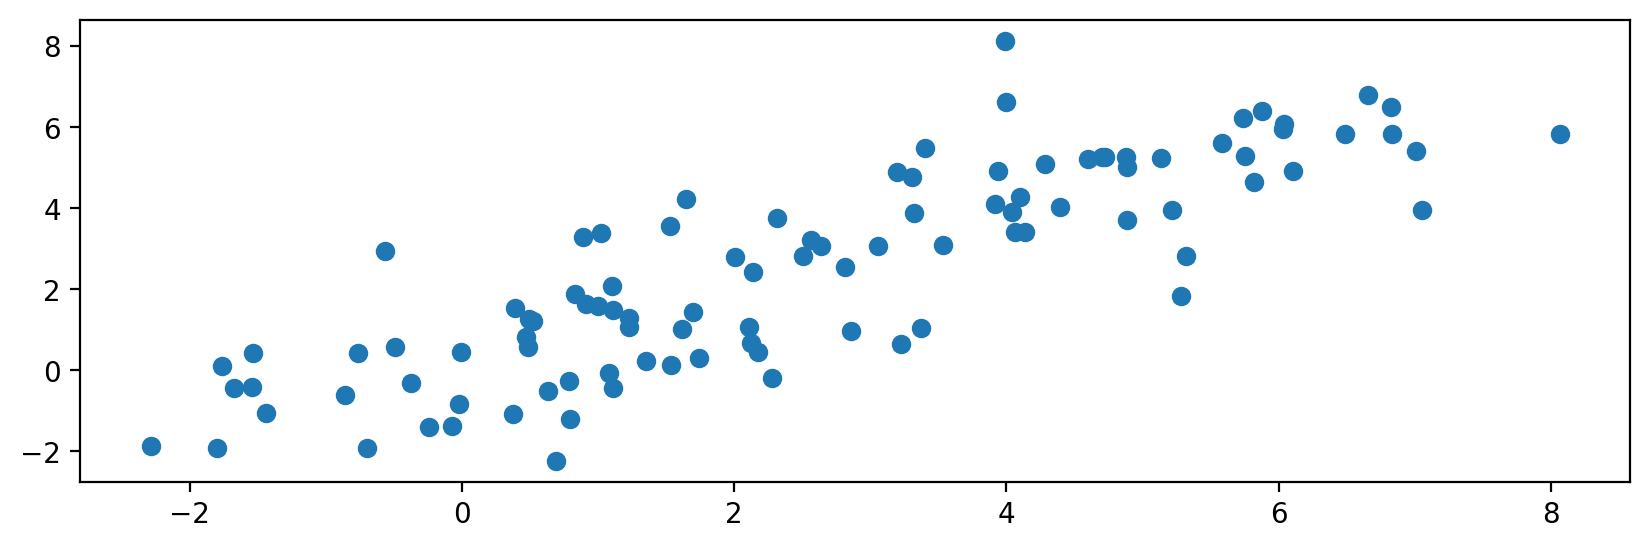

In [268]:
y_fitted = np.random.normal(beta_0_fit + beta_1_fit * x, 1 / np.sqrt(tau_fit))

plt.scatter(y, y_fitted)

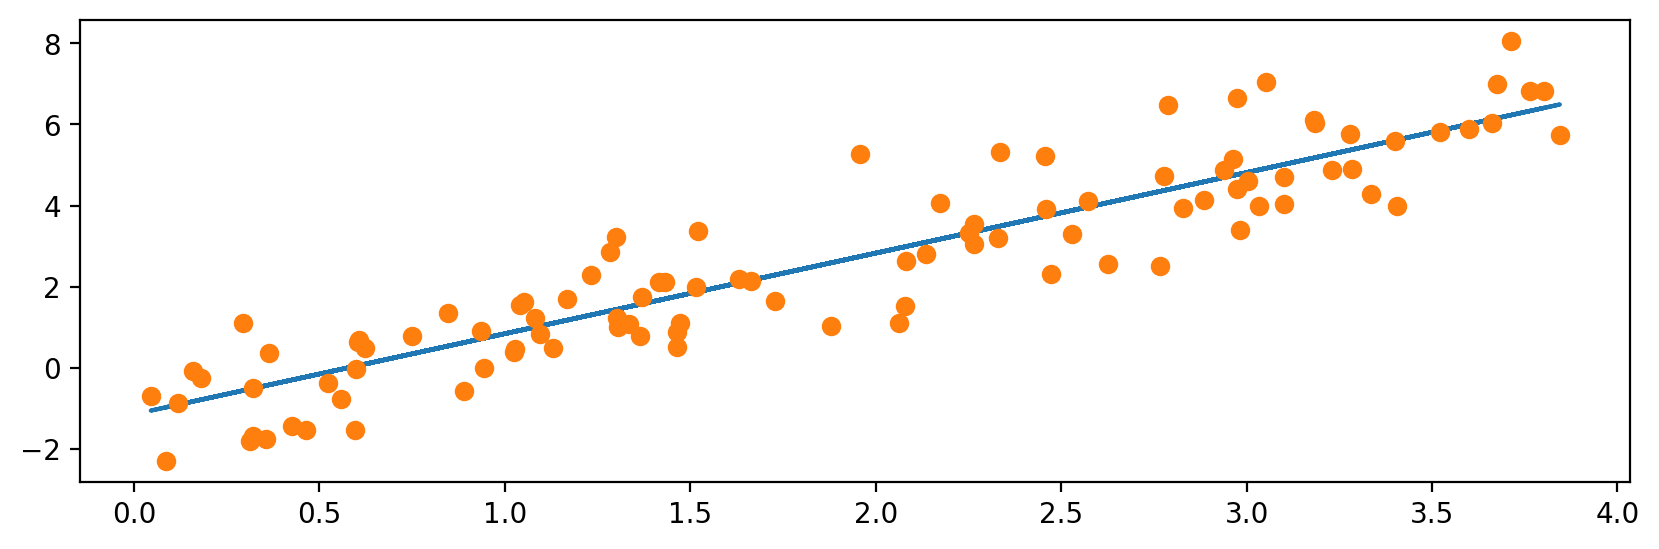

In [269]:
y_fitted = beta_0_fit + beta_1_fit * x
plt.plot(x, y_fitted)
plt.plot(x, y, "o")

# References
1. Mackay, D.J.C. (1998). Introduction to Monte Carlo Methods. In: Jordan, M.I. (eds) Learning in Graphical Models. NATO ASI Series, vol 89. Springer, Dordrecht. https://doi.org/10.1007/978-94-011-5014-9_7
2. Gibbs Sampling Is a Special Case of Metropolis–Hastings. https://gregorygundersen.com/blog/2020/02/23/gibbs-sampling/
3. Implementing MCMC - the Metropolis algorithm. https://www.tcbegley.com/blog/posts/mcmc-part-1
4. Implementing MCMC - Hamiltonian Monte Carlo. https://www.tcbegley.com/blog/posts/mcmc-part-2
5. https://glizen.com/radfordneal/csc2541.S11/week3.pdf